In [139]:
import numpy as np
import pandas as pd

In [140]:
df = pd.read_csv("https://raw.githubusercontent.com/muajnstu/ML-Datasets/refs/heads/main/breast-cancer-data.csv")
df

,age,menopause,tumer-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiate,class
0,40-49',premeno',15-19',0-2',yes',3',right',left_up',no',recurrence-events'
1,50-59',ge40',15-19',0-2',no',1',right',central',no',no-recurrence-events'
2,50-59',ge40',35-39',0-2',no',2',left',left_low',no',recurrence-events'
3,40-49',premeno',35-39',0-2',yes',3',right',left_low',yes',no-recurrence-events'
4,40-49',premeno',30-34',3-5',yes',2',left',right_up',no',recurrence-events'
...,...,...,...,...,...,...,...,...,...,...
281,50-59',ge40',30-34',6-8',yes',2',left',left_low',no',no-recurrence-events'
282,50-59',premeno',25-29',3-5',yes',2',left',left_low',yes',no-recurrence-events'
283,30-39',premeno',30-34',6-8',yes',2',right',right_up',no',no-recurrence-events'
284,50-59',premeno',15-19',0-2',no',2',right',left_low',no',no-recurrence-events'


In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          286 non-null    object
 1   menopause    286 non-null    object
 2   tumer-size   286 non-null    object
 3   inv-nodes    286 non-null    object
 4   node-caps    278 non-null    object
 5   deg-malig    286 non-null    object
 6   breast       286 non-null    object
 7   breast-quad  285 non-null    object
 8   irradiate    286 non-null    object
 9   class        286 non-null    object
dtypes: object(10)
memory usage: 22.5+ KB


In [142]:
# Missing values per column
missing_per_column = df.isnull().sum()
print("Missing values per column:")
print(missing_per_column)

# Total missing values in all columns
print("Total missing values in all columns:", missing_per_column.sum())

# Missing values per row
missing_per_row = df.isnull().sum(axis=1)
print("Missing values per row:")
print(missing_per_row)

# Total missing values in all rows
print("Total missing values in all rows:", missing_per_row.sum())

# Total missing values in the dataset
total_missing = df.isnull().sum().sum()
print("Total missing values in the dataset:", total_missing)

Missing values per column:
age            0
menopause      0
tumer-size     0
inv-nodes      0
node-caps      8
deg-malig      0
breast         0
breast-quad    1
irradiate      0
class          0
dtype: int64
Total missing values in all columns: 9
Missing values per row:
0      0
1      0
2      0
3      0
4      0
      ..
281    0
282    0
283    0
284    0
285    0
Length: 286, dtype: int64
Total missing values in all rows: 9
Total missing values in the dataset: 9


In [143]:
# highlight the missing columns
print("\nColumns with missing values:")
print(missing_per_column[missing_per_column > 0])


# Show the rows with missing values
print("\nRows with missing values:")
display(df[df.isnull().any(axis=1)])


Columns with missing values:
node-caps      8
breast-quad    1
dtype: int64

Rows with missing values:


,age,menopause,tumer-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiate,class
20,50-59',lt40',20-24',0-2',NaN,1',left',left_low',no',recurrence-events'
31,60-69',ge40',25-29',3-5',NaN,1',right',left_low',yes',no-recurrence-events'
50,70-79',ge40',15-19',9-11',NaN,1',left',left_low',yes',recurrence-events'
54,40-49',premeno',25-29',0-2',NaN,2',left',right_low',yes',no-recurrence-events'
71,60-69',ge40',25-29',3-5',NaN,1',right',left_up',yes',no-recurrence-events'
92,50-59',lt40',20-24',0-2',NaN,1',left',left_up',no',recurrence-events'
149,50-59',ge40',30-34',9-11',NaN,3',left',left_up',yes',no-recurrence-events'
240,50-59',ge40',30-34',0-2',no',3',left',NaN,no',recurrence-events'
264,50-59',ge40',30-34',9-11',NaN,3',left',left_low',yes',no-recurrence-events'


In [144]:
from collections import Counter
from sklearn.impute import KNNImputer
import numpy as np
import pandas as pd

# ===============================
#  1️⃣ HELPER FUNCTIONS
# ===============================

def delta(a, b):
    """Return 1 if a == b, else 0."""
    return int(a == b)


def impute_sim_hamm(row, complete_df, target_col, compare_cols):
    """
    Impute missing categorical values using similarity-based Hamming distance.

    Parameters:
    ----------
    row : pandas.Series
        The row with missing value.
    complete_df : pandas.DataFrame
        Subset of data without missing target values.
    target_col : str
        Column name to impute.
    compare_cols : list
        Columns to calculate similarity on.
    """
    complete_df = complete_df.dropna(subset=compare_cols)

    # Print the number of complete rows being used
    # print(f"Number of complete rows for imputation: {len(complete_df)}")

    # Compute similarity scores
    sim_scores = [
        (comp[target_col], sum(delta(row[c], comp[c]) for c in compare_cols))
        for _, comp in complete_df.iterrows()
    ]

    # Find maximum similarity score
    if not sim_scores:
        return np.nan

    max_score = max(score for _, score in sim_scores)
    top_sim = [val for val, score in sim_scores if score == max_score]

    # Majority vote among top similar rows
    count = Counter(top_sim)

    # If tie, use Hamming distance to break it
    if len(count) > 1:
        hamm_scores = [
            (comp[target_col], sum(row[c] != comp[c] for c in compare_cols))
            for _, comp in complete_df.iterrows()
        ]
        min_hamm = min(h[1] for h in hamm_scores)
        candidates = [h[0] for h in hamm_scores if h[1] == min_hamm]
        return Counter(candidates).most_common(1)[0][0]

    return list(count.keys())[0]


# ===============================
#  2️⃣ MAIN IMPUTATION FUNCTION
# ===============================

def handle_missing_values(df):
    """
    Cleans and imputes missing values for 'node_caps' and 'breast_quad'.
    Uses:
      - Mode imputation for node_caps
      - KNN Imputation for breast_quad
    """
    df = df.copy()

    # --- Handle 'node-caps' using Mode Imputation ---
    if df['node-caps'].isnull().any():
        mode_node_caps = df['node-caps'].mode()[0]
        df['node-caps'] = df['node-caps'].fillna(mode_node_caps)
        print(f"Imputed missing 'node-caps' with mode: {mode_node_caps}")


    # --- Handle 'breast-quad' using KNN ---
    if df['breast-quad'].isnull().any():
        df_bq = df.copy()
        df_bq['breast-quad_cat'] = df_bq['breast-quad'].astype('category')
        df_bq['breast-quad_code'] = df_bq['breast-quad_cat'].cat.codes.replace(-1, np.nan)

        knn_imputer = KNNImputer(n_neighbors=5)
        # Reshape for KNNImputer
        breast_quad_code_reshaped = df_bq[['breast-quad_code']]
        df_bq[['breast-quad_code']] = knn_imputer.fit_transform(breast_quad_code_reshaped)

        mapping = dict(enumerate(df_bq['breast-quad_cat'].cat.categories))
        df['breast-quad'] = df_bq['breast-quad_code'].round().astype(int).map(mapping)
        print("Imputed missing 'breast-quad' using KNN.")


    print("✅ Missing data handled successfully!")
    print("\nRemaining missing values:\n")
    print(df.isna().sum())

    return df

In [145]:
# Check for duplicate rows
duplicate_rows = df.duplicated()
print("Duplicate rows (True means duplicate):")
print(duplicate_rows)

# Total number of duplicate rows
total_duplicates = duplicate_rows.sum()
print("Total number of duplicate rows:", total_duplicates)

Duplicate rows (True means duplicate):
0      False
1      False
2      False
3      False
4      False
       ...  
281    False
282    False
283    False
284    False
285    False
Length: 286, dtype: bool
Total number of duplicate rows: 14


In [146]:
df[df.duplicated(keep=False)].sort_values(by=list(df.columns))


,age,menopause,tumer-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiate,class
35,30-39',premeno',15-19',0-2',no',1',left',left_low',no',no-recurrence-events'
44,30-39',premeno',15-19',0-2',no',1',left',left_low',no',no-recurrence-events'
40,30-39',premeno',35-39',0-2',no',3',left',left_low',no',recurrence-events'
267,30-39',premeno',35-39',0-2',no',3',left',left_low',no',recurrence-events'
23,40-49',premeno',10-14',0-2',no',1',right',left_up',no',no-recurrence-events'
27,40-49',premeno',10-14',0-2',no',1',right',left_up',no',no-recurrence-events'
175,40-49',premeno',20-24',0-2',no',2',right',left_up',no',no-recurrence-events'
214,40-49',premeno',20-24',0-2',no',2',right',left_up',no',no-recurrence-events'
133,40-49',premeno',25-29',0-2',no',2',right',left_low',no',recurrence-events'
178,40-49',premeno',25-29',0-2',no',2',right',left_low',no',recurrence-events'


In [147]:
df[df.duplicated(keep=False)].sort_values(by=list(df.columns))

# Remove exact duplicates
df.drop_duplicates(inplace=True)

# Verify removal
print("Remaining duplicate rows:", df.duplicated().sum())

duplicates = df[df.duplicated(keep=False)]
duplicates.to_csv("removed_duplicates.csv", index=False)

Remaining duplicate rows: 0


In [148]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Calculate statistics
print("Statistical Calculations for Numeric Columns:\n")

for col in numeric_cols:
    print(f"Column: {col}")
    print(f"  Mean: {df[col].mean()}")
    print(f"  Median: {df[col].median()}")
    print(f"  Mode: {df[col].mode()[0] if not df[col].mode().empty else 'No mode'}")
    print(f"  Min: {df[col].min()}")
    print(f"  Max: {df[col].max()}")
    print(f"  Standard Deviation: {df[col].std()}")
    print(f"  Variance: {df[col].var()}")
    print("")

# If you want a summary for all numeric columns, you can use:
print("Summary Statistics for All Numeric Columns:")
print(df.describe())

Statistical Calculations for Numeric Columns:

Summary Statistics for All Numeric Columns:
           age menopause tumer-size inv-nodes node-caps deg-malig breast  \
count      272       272        272       272       264       272    272   
unique       6         3         11         7         2         3      2   
top     50-59'  premeno'     30-34'      0-2'       no'        2'  left'   
freq        91       143         60       200       209       124    143   

       breast-quad irradiate                  class  
count          271       272                    272  
unique           5         2                      2  
top      left_low'       no'  no-recurrence-events'  
freq           103       205                    191  


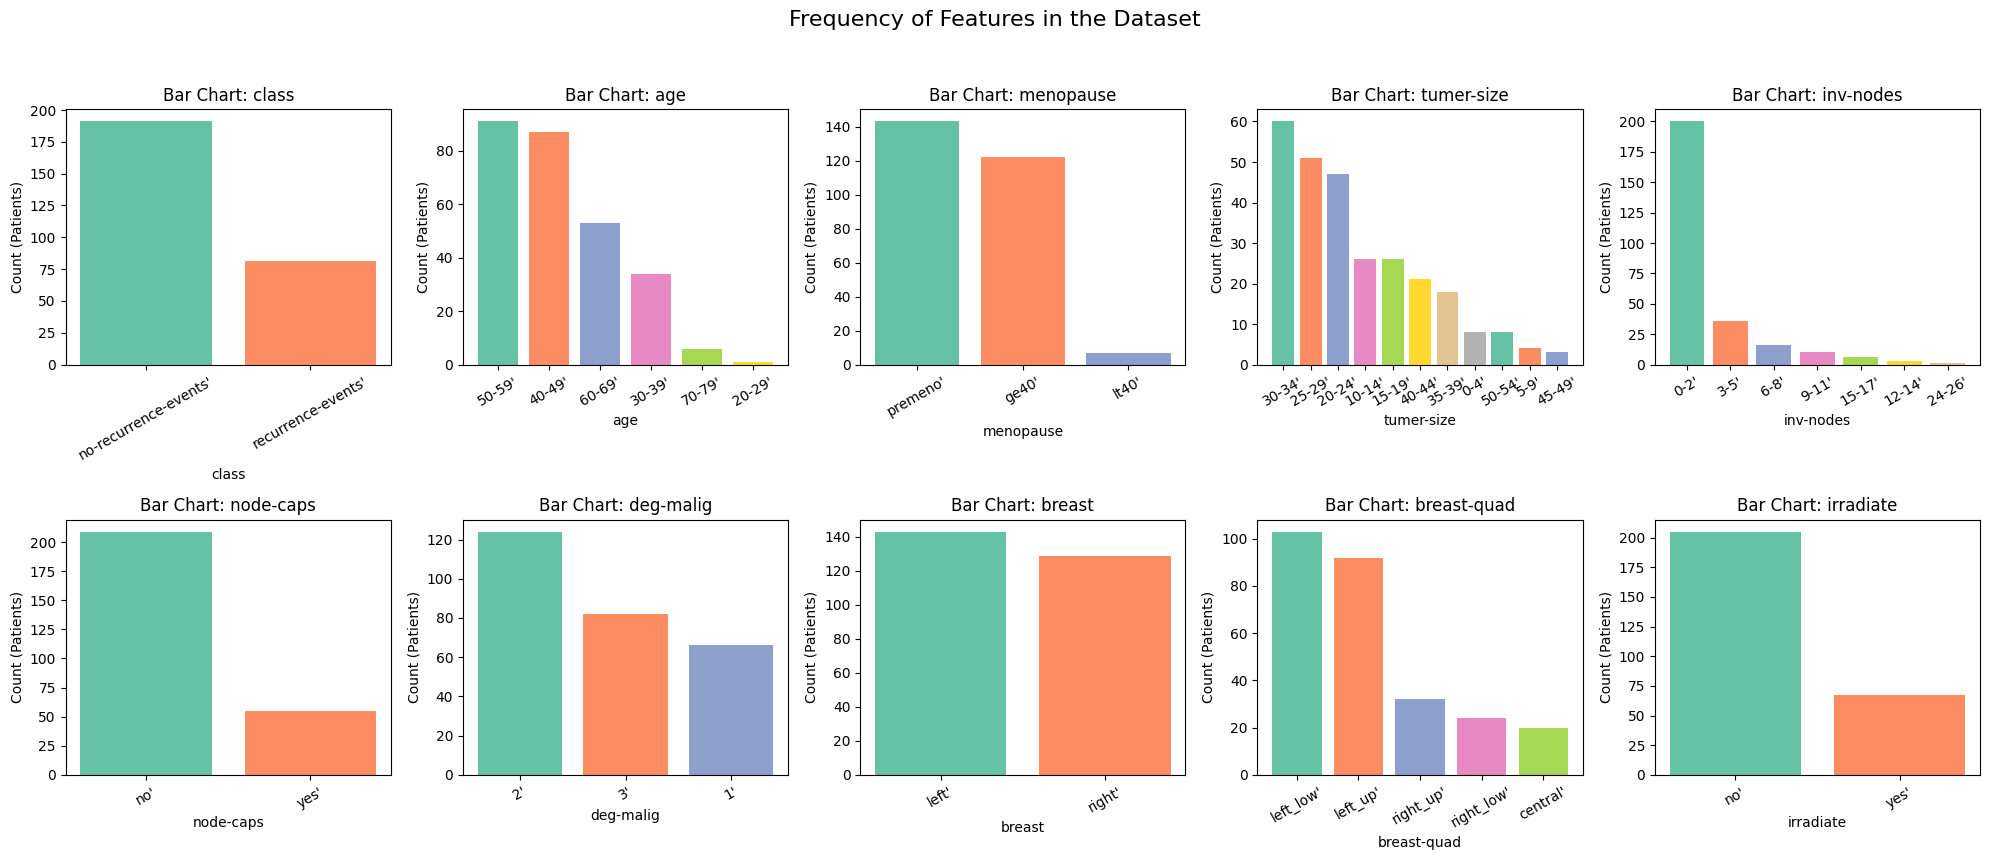

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt

columns = ['class', 'age', 'menopause', 'tumer-size', 'inv-nodes', 'node-caps',
           'deg-malig', 'breast', 'breast-quad', 'irradiate']

colors = sns.color_palette("Set2", n_colors=10)

fig, axes = plt.subplots(2, 5, figsize=(20, 9))
fig.suptitle('Frequency of Features in the Dataset', fontsize=16) # Translated

for ax, column, color in zip(axes.flat, columns, colors):
    counts = df[column].value_counts()
    bars = ax.bar(counts.index.astype(str), counts.values, color=sns.color_palette("Set2", n_colors=len(counts)))
    ax.set_title('Bar Chart: '+ column)
    ax.set_xlabel(column)
    ax.set_ylabel('Count (Patients)') # Translated
    ax.tick_params(axis='x', rotation=30)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

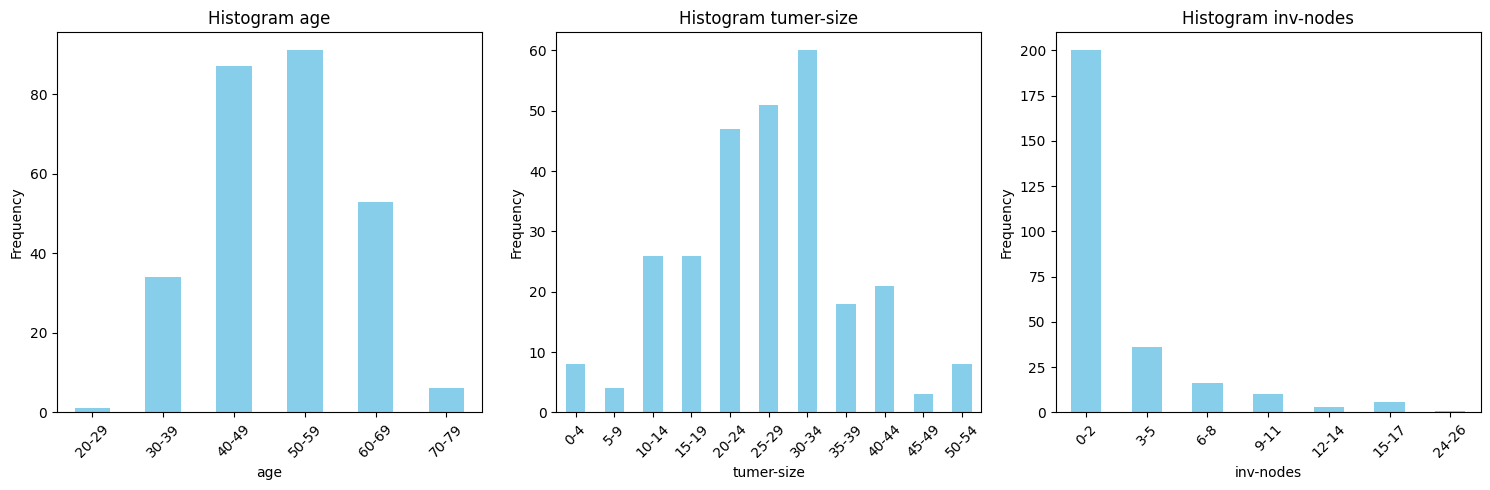

In [150]:
kategori_map = {
    'age': ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79'],
    'tumer-size': ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29',
                   '30-34', '35-39', '40-44', '45-49', '50-54'],
    'inv-nodes': ['0-2', '3-5', '6-8', '9-11', '12-14', '15-17', '24-26']
}

df_plot = df.copy()

for col, cat_order in kategori_map.items():
    # Remove trailing apostrophe from column values
    df_plot[col] = df_plot[col].str.replace("'", "")
    df_plot[col] = pd.Categorical(df_plot[col], categories=cat_order, ordered=True)

features_for_hist = ['age', 'tumer-size', 'inv-nodes']
plt.figure(figsize=(20, 5))
for i, feature in enumerate(features_for_hist):
    plt.subplot(1, 4, i + 1)
    df_plot[feature].value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.title(f'Histogram {feature}')
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [151]:
df.isnull().sum()

,0
age,0
menopause,0
tumer-size,0
inv-nodes,0
node-caps,8
deg-malig,0
breast,0
breast-quad,1
irradiate,0
class,0


In [152]:
# Store indices of missing values *before* imputation
missing_node_caps_idx = df[df['node-caps'].isna()].index
missing_breast_quad_idx = df[df['breast-quad'].isna()].index

# Run the imputation function
df_imputed = handle_missing_values(df)

# Show exactly those that were imputed
print("\n🩺 Rows where 'node-caps' was imputed:")
print(df_imputed.loc[missing_node_caps_idx, ['age', 'tumer-size', 'deg-malig', 'irradiate', 'node-caps']])

print("\n🧬 Row where 'breast-quad' was imputed:")
print(df_imputed.loc[missing_breast_quad_idx, ['age', 'tumer-size', 'deg-malig', 'irradiate', 'breast-quad']])

Imputed missing 'node-caps' with mode: no'
Imputed missing 'breast-quad' using KNN.
✅ Missing data handled successfully!

Remaining missing values:

age            0
menopause      0
tumer-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiate      0
class          0
dtype: int64

🩺 Rows where 'node-caps' was imputed:
        age tumer-size deg-malig irradiate node-caps
20   50-59'     20-24'        1'       no'       no'
31   60-69'     25-29'        1'      yes'       no'
50   70-79'     15-19'        1'      yes'       no'
54   40-49'     25-29'        2'      yes'       no'
71   60-69'     25-29'        1'      yes'       no'
92   50-59'     20-24'        1'       no'       no'
149  50-59'     30-34'        3'      yes'       no'
264  50-59'     30-34'        3'      yes'       no'

🧬 Row where 'breast-quad' was imputed:
        age tumer-size deg-malig irradiate breast-quad
240  50-59'     30-34'        3'       no'    left_up'


In [153]:
df_imputed.isnull().sum()

,0
age,0
menopause,0
tumer-size,0
inv-nodes,0
node-caps,0
deg-malig,0
breast,0
breast-quad,0
irradiate,0
class,0


In [154]:
# Store indices of missing values *before* imputation
missing_node_caps_idx = df[df['node-caps'].isna()].index
missing_breast_quad_idx = df[df['breast-quad'].isna()].index

# Run the imputation function
df_imputed = handle_missing_values(df)

# Show exactly those that were imputed
print("\n🩺 Rows where 'node-caps' was imputed:")
print(df_imputed.loc[missing_node_caps_idx, ['age', 'tumer-size', 'deg-malig', 'irradiate', 'node-caps']])

print("\n🧬 Row where 'breast-quad' was imputed:")
print(df_imputed.loc[missing_breast_quad_idx, ['age', 'tumer-size', 'deg-malig', 'irradiate', 'breast-quad']])

Imputed missing 'node-caps' with mode: no'
Imputed missing 'breast-quad' using KNN.
✅ Missing data handled successfully!

Remaining missing values:

age            0
menopause      0
tumer-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiate      0
class          0
dtype: int64

🩺 Rows where 'node-caps' was imputed:
        age tumer-size deg-malig irradiate node-caps
20   50-59'     20-24'        1'       no'       no'
31   60-69'     25-29'        1'      yes'       no'
50   70-79'     15-19'        1'      yes'       no'
54   40-49'     25-29'        2'      yes'       no'
71   60-69'     25-29'        1'      yes'       no'
92   50-59'     20-24'        1'       no'       no'
149  50-59'     30-34'        3'      yes'       no'
264  50-59'     30-34'        3'      yes'       no'

🧬 Row where 'breast-quad' was imputed:
        age tumer-size deg-malig irradiate breast-quad
240  50-59'     30-34'        3'       no'    left_up'


In [155]:
# Store indices of missing values *before* imputation
missing_node_caps_idx = df[df['node-caps'].isna()].index
missing_breast_quad_idx = df[df['breast-quad'].isna()].index

# Run the imputation function
df_imputed = handle_missing_values(df)

# Show exactly those that were imputed
print("\n🩺 Rows where 'node-caps' was imputed:")
print(df_imputed.loc[missing_node_caps_idx, ['age', 'tumer-size', 'deg-malig', 'irradiate', 'node-caps']])

print("\n🧬 Row where 'breast-quad' was imputed:")
print(df_imputed.loc[missing_breast_quad_idx, ['age', 'tumer-size', 'deg-malig', 'irradiate', 'breast-quad']])

Imputed missing 'node-caps' with mode: no'
Imputed missing 'breast-quad' using KNN.
✅ Missing data handled successfully!

Remaining missing values:

age            0
menopause      0
tumer-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiate      0
class          0
dtype: int64

🩺 Rows where 'node-caps' was imputed:
        age tumer-size deg-malig irradiate node-caps
20   50-59'     20-24'        1'       no'       no'
31   60-69'     25-29'        1'      yes'       no'
50   70-79'     15-19'        1'      yes'       no'
54   40-49'     25-29'        2'      yes'       no'
71   60-69'     25-29'        1'      yes'       no'
92   50-59'     20-24'        1'       no'       no'
149  50-59'     30-34'        3'      yes'       no'
264  50-59'     30-34'        3'      yes'       no'

🧬 Row where 'breast-quad' was imputed:
        age tumer-size deg-malig irradiate breast-quad
240  50-59'     30-34'        3'       no'    left_up'


In [156]:
df_imputed.isnull().sum()

,0
age,0
menopause,0
tumer-size,0
inv-nodes,0
node-caps,0
deg-malig,0
breast,0
breast-quad,0
irradiate,0
class,0


In [157]:
# Store indices of missing values *before* imputation
missing_node_caps_idx = df[df['node-caps'].isna()].index
missing_breast_quad_idx = df[df['breast-quad'].isna()].index

# Run the imputation function
df_imputed = handle_missing_values(df)

# Show exactly those that were imputed
print("\n🩺 Rows where 'node-caps' was imputed:")
print(df_imputed.loc[missing_node_caps_idx, ['age', 'tumer-size', 'deg-malig', 'irradiate', 'node-caps']])

print("\n🧬 Row where 'breast-quad' was imputed:")
print(df_imputed.loc[missing_breast_quad_idx, ['age', 'tumer-size', 'deg-malig', 'irradiate', 'breast-quad']])

Imputed missing 'node-caps' with mode: no'
Imputed missing 'breast-quad' using KNN.
✅ Missing data handled successfully!

Remaining missing values:

age            0
menopause      0
tumer-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiate      0
class          0
dtype: int64

🩺 Rows where 'node-caps' was imputed:
        age tumer-size deg-malig irradiate node-caps
20   50-59'     20-24'        1'       no'       no'
31   60-69'     25-29'        1'      yes'       no'
50   70-79'     15-19'        1'      yes'       no'
54   40-49'     25-29'        2'      yes'       no'
71   60-69'     25-29'        1'      yes'       no'
92   50-59'     20-24'        1'       no'       no'
149  50-59'     30-34'        3'      yes'       no'
264  50-59'     30-34'        3'      yes'       no'

🧬 Row where 'breast-quad' was imputed:
        age tumer-size deg-malig irradiate breast-quad
240  50-59'     30-34'        3'       no'    left_up'


In [158]:
df_imputed.isnull().sum()

,0
age,0
menopause,0
tumer-size,0
inv-nodes,0
node-caps,0
deg-malig,0
breast,0
breast-quad,0
irradiate,0
class,0


In [159]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Calculate statistics
print("Statistical Calculations for Numeric Columns:\n")

for col in numeric_cols:
    print(f"Column: {col}")
    print(f"  Mean: {df[col].mean()}")
    print(f"  Median: {df[col].median()}")
    print(f"  Mode: {df[col].mode()[0] if not df[col].mode().empty else 'No mode'}")
    print(f"  Min: {df[col].min()}")
    print(f"  Max: {df[col].max()}")
    print(f"  Standard Deviation: {df[col].std()}")
    print(f"  Variance: {df[col].var()}")
    print("")

# If you want a summary for all numeric columns, you can use:
print("Summary Statistics for All Numeric Columns:")
print(df.describe())

Statistical Calculations for Numeric Columns:

Summary Statistics for All Numeric Columns:
           age menopause tumer-size inv-nodes node-caps deg-malig breast  \
count      272       272        272       272       264       272    272   
unique       6         3         11         7         2         3      2   
top     50-59'  premeno'     30-34'      0-2'       no'        2'  left'   
freq        91       143         60       200       209       124    143   

       breast-quad irradiate                  class  
count          271       272                    272  
unique           5         2                      2  
top      left_low'       no'  no-recurrence-events'  
freq           103       205                    191  


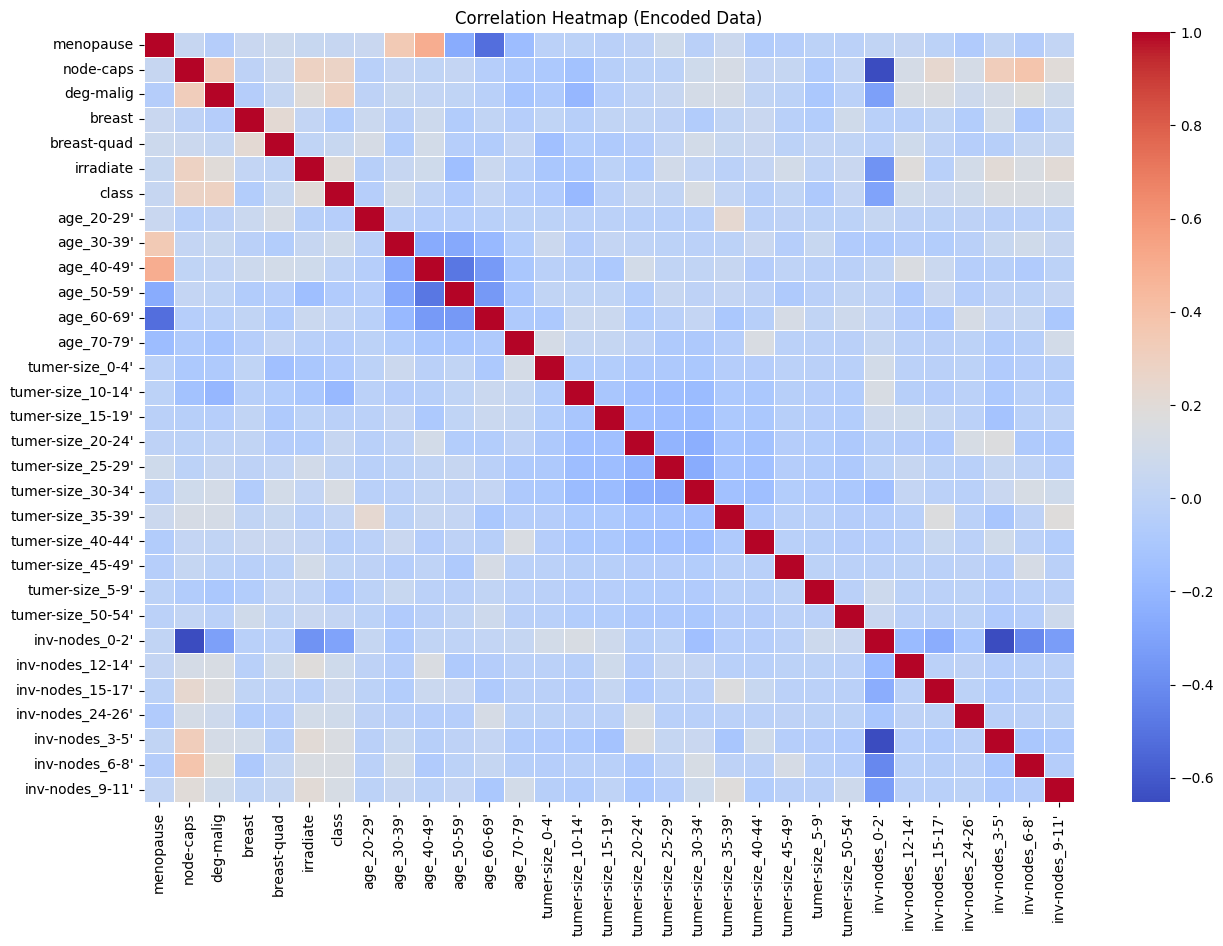

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Create a copy of the imputed DataFrame
df_encoded = df_imputed.copy()

# Define columns for different encoding methods
label_encode_cols = ['menopause', 'node-caps', 'deg-malig', 'breast', 'irradiate', 'class', 'breast-quad']
one_hot_encode_cols = ['age', 'tumer-size', 'inv-nodes'] # Based on unique value counts closest to 8-10 range

# Apply Label Encoding
for col in label_encode_cols:
    le = LabelEncoder()
    # Remove trailing apostrophe before encoding
    df_encoded[col] = df_encoded[col].astype(str).str.replace("'", "")
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Apply One-Hot Encoding
df_encoded = pd.get_dummies(df_encoded, columns=one_hot_encode_cols, prefix=one_hot_encode_cols)

# Calculate the correlation matrix
corr_matrix = df_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap (Encoded Data)')
plt.show()

In [161]:
# Get correlations with the target variable 'class'
class_correlations = corr_matrix['class'].sort_values(ascending=False)

# Display the correlations
print("Correlation with 'class' (Target Variable):")
print(class_correlations)

Correlation with 'class' (Target Variable):
class                1.000000
deg-malig            0.286857
node-caps            0.272658
irradiate            0.187485
inv-nodes_3-5'       0.148978
inv-nodes_6-8'       0.144715
tumer-size_30-34'    0.138293
inv-nodes_9-11'      0.129111
age_30-39'           0.094201
inv-nodes_24-26'     0.093280
inv-nodes_12-14'     0.085186
inv-nodes_15-17'     0.066411
breast-quad          0.046996
tumer-size_20-24'    0.042609
menopause            0.038779
tumer-size_50-54'    0.029390
age_60-69'           0.024701
tumer-size_35-39'    0.020689
tumer-size_25-29'    0.016736
tumer-size_45-49'    0.008207
age_40-49'           0.001584
tumer-size_15-19'   -0.020307
tumer-size_40-44'   -0.037761
age_20-29'          -0.039559
age_70-79'          -0.043066
breast              -0.054991
tumer-size_0-4'     -0.065778
age_50-59'          -0.069848
tumer-size_5-9'     -0.079559
tumer-size_10-14'   -0.184368
inv-nodes_0-2'      -0.301757
Name: class, dtype: float6

In [162]:
# Save the processed DataFrame to a new CSV file
df_imputed.to_csv('processed_breast_cancer_data.csv', index=False)

print("Processed DataFrame saved to 'processed_breast_cancer_data.csv'")

Processed DataFrame saved to 'processed_breast_cancer_data.csv'
